<a href="https://colab.research.google.com/github/Ankit-dev-ui/plant-disease-detection-modal/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Setup and Dataset Preparation
!wget -O "dataset.zip" "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded"
!unzip /content/dataset.zip

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

!pip install split-folders
import splitfolders
splitfolders.ratio('/content/Plant_leave_diseases_dataset_with_augmentation', output="dataset", seed=1337, ratio=(.8, .1,.1))


Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1327).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1328).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1329).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (133).JPG  
  inflating: Plant_leave_diseases_dataset_with_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1330).JPG  
  infl

Copying files: 61486 files [00:11, 5151.85 files/s]


Found 49179 files belonging to 39 classes.
Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


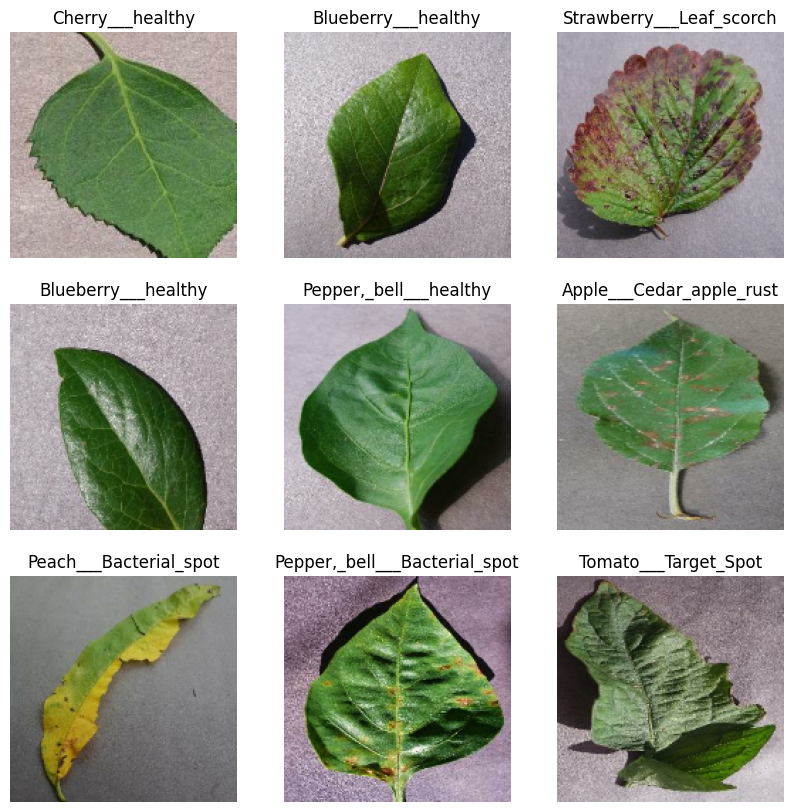

In [ ]:
# 2. Dataset Loading
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"
test_dir = "/content/dataset/test"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

class_names = train_dataset.class_names


# Preview image samples
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

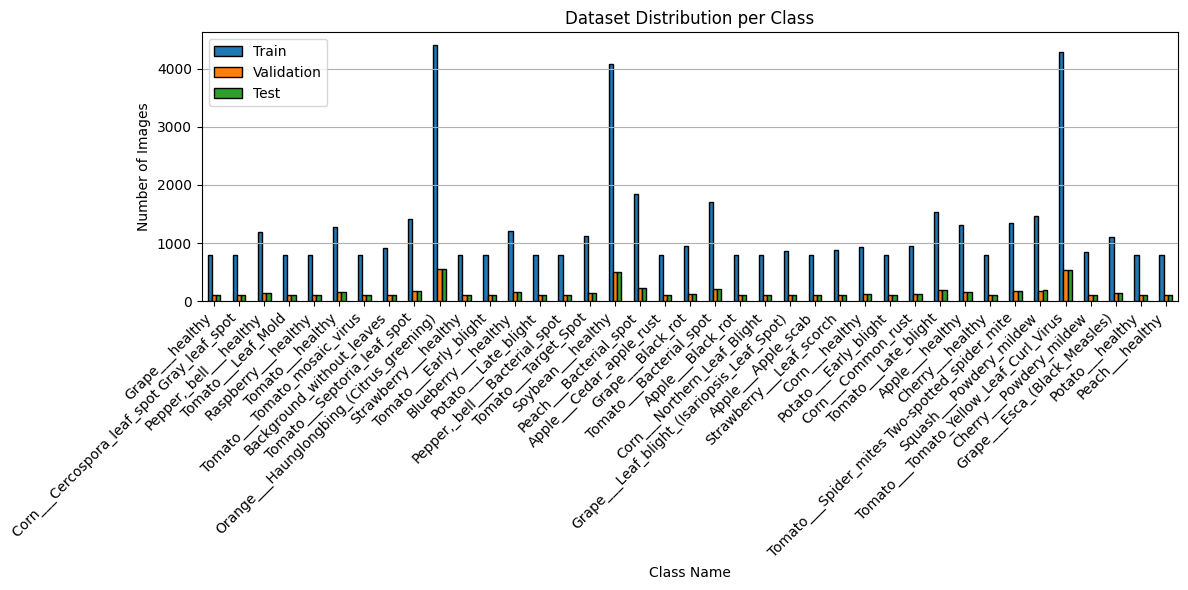

In [ ]:
# Dataset Distribution Plot

def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Get counts
train_counts = get_class_distribution(train_dir)
val_counts = get_class_distribution(validation_dir)
test_counts = get_class_distribution(test_dir)

# Convert to DataFrame
df_dist = pd.DataFrame({
    "Train": pd.Series(train_counts),
    "Validation": pd.Series(val_counts),
    "Test": pd.Series(test_counts)
}).fillna(0).astype(int)

# Plot
df_dist.plot(kind='bar', figsize=(12, 6), edgecolor='black')
plt.title('Dataset Distribution per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 3. Model Building - DenseNet121
from tensorflow.keras.applications import DenseNet121

IMG_SHAPE = IMG_SIZE + (3,)
base_model = DenseNet121(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.applications.densenet.preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# 4. Initial Training
initial_epochs = 6
loss0, accuracy0 = model.evaluate(validation_dataset)

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


192/192 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.0394 - loss: 4.8569
Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 107s 54ms/step - accuracy: 0.6984 - loss: 1.1664 - val_accuracy: 0.9464 - val_loss: 0.1986
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 123s 48ms/step - accuracy: 0.9286 - loss: 0.2361 - val_accuracy: 0.9562 - val_loss: 0.1496
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.9393 - loss: 0.1886 - val_accuracy: 0.9645 - val_loss: 0.1243
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9463 - loss: 0.1614 - val_accuracy: 0.9635 - val_loss: 0.1245
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9520 - loss: 0.1503 - val_accuracy: 0.9647 - val_loss: 0.1215
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.9528 - loss: 0.1438 - val_accuracy: 0.9627 - val_loss: 0.1219


In [ ]:
# 5. Fine-Tuning
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 6/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 397s 180ms/step - accuracy: 0.6531 - loss: 2.4535 - val_accuracy: 0.9757 - val_loss: 0.0974
Epoch 7/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 210s 113ms/step - accuracy: 0.9592 - loss: 0.1275 - val_accuracy: 0.9844 - val_loss: 0.0672
Epoch 8/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 202s 113ms/step - accuracy: 0.9774 - loss: 0.0702 - val_accuracy: 0.9878 - val_loss: 0.0542
Epoch 9/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 202s 113ms/step - accuracy: 0.9857 - loss: 0.0425 - val_accuracy: 0.9894 - val_loss: 0.0478
Epoch 10/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 205s 116ms/step - accuracy: 0.9917 - loss: 0.0262 - val_accuracy: 0.9920 - val_loss: 0.0415
Epoch 11/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 202s 116ms/step - accuracy: 0.9946 - loss: 0.0171 - val_accuracy: 0.9917 - val_loss: 0.0410
Epoch 12/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 178s 116ms/step - accuracy: 0.9956 - loss: 0.0138 - val_accuracy: 0.9930 - val_loss: 0.0384
Epoch 13/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 206s 119ms/step 

In [ ]:
# 6. Evaluation
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

# 7. Metrics: Confusion Matrix, Classification Report, ROC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

y_true = []
y_pred = []
y_score = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_score.extend(preds)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)


193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9937 - loss: 0.0236
Test accuracy : 0.9948119521141052
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━

In [ ]:
# Training & Validation Graphs
acc = history.history['accuracy'] + history_fine.history['accuracy'][1:]
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy'][1:]

loss = history.history['loss'] + history_fine.history['loss'][1:]
val_loss = history.history['val_loss'] + history_fine.history['val_loss'][1:]

epochs_range = range(len(acc))  # or use total_epochs - 1

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'history' is not defined

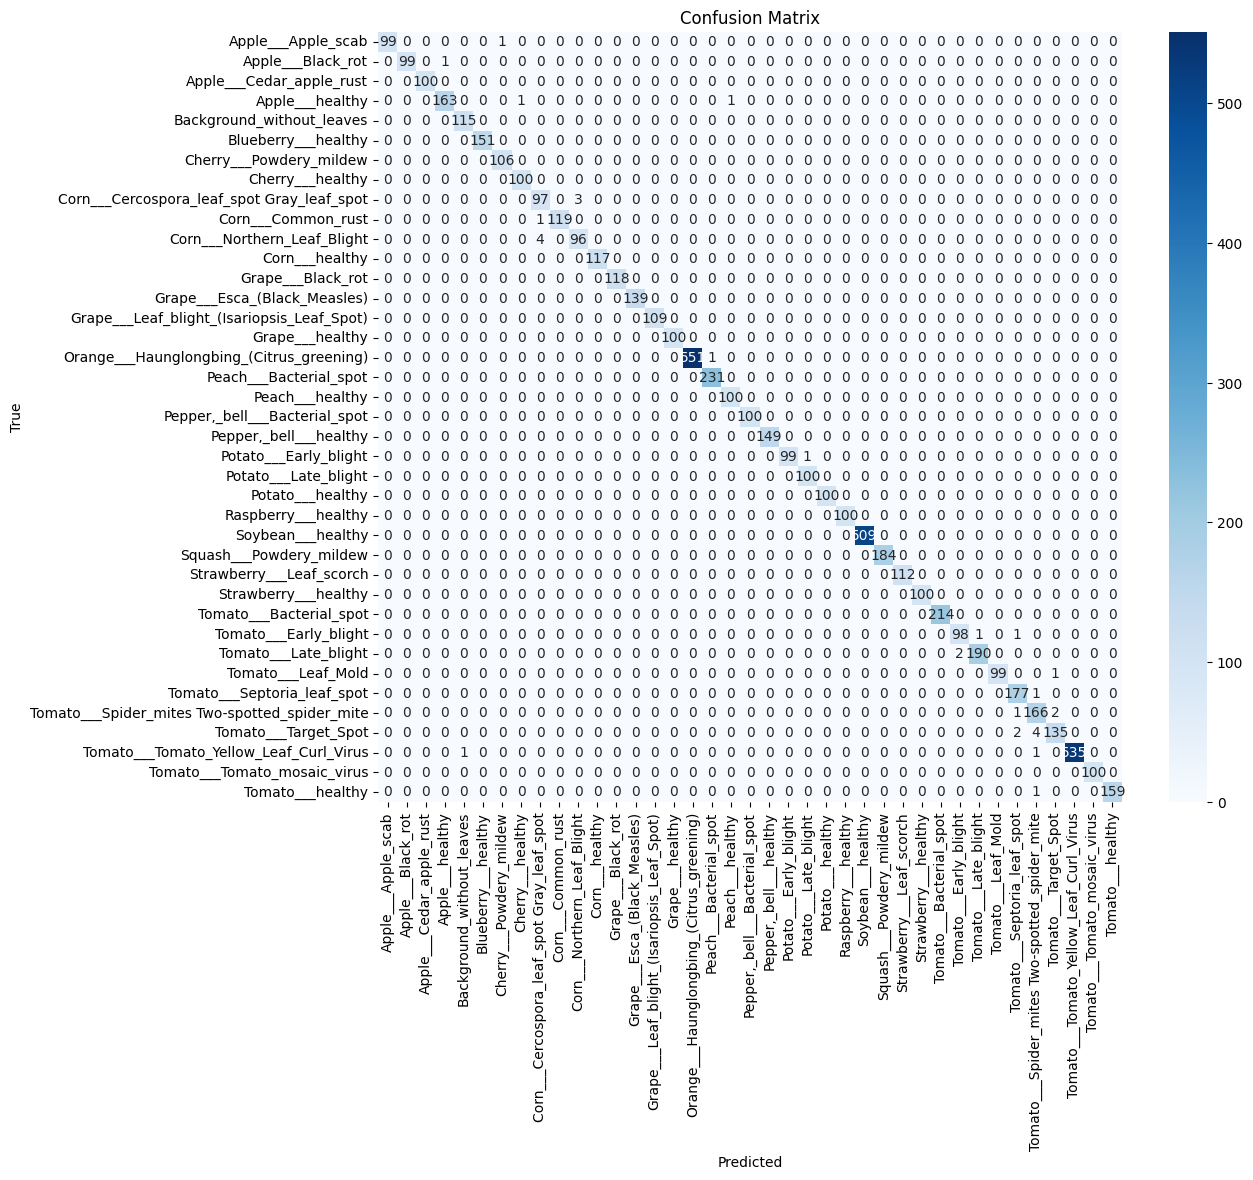

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.99      0.99       100
                            Apple___Black_rot       1.00      0.99      0.99       100
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       100
                              Apple___healthy       0.99      0.99      0.99       165
                    Background_without_leaves       0.99      1.00      1.00       115
                          Blueberry___healthy       1.00      1.00      1.00       151
                      Cherry___Powdery_mildew       0.99      1.00      1.00       106
                             Cherry___healthy       0.99      1.00      1.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.97      0.96       100
                           Corn___Common_rust       1.00      0.99      1.00       120
                  

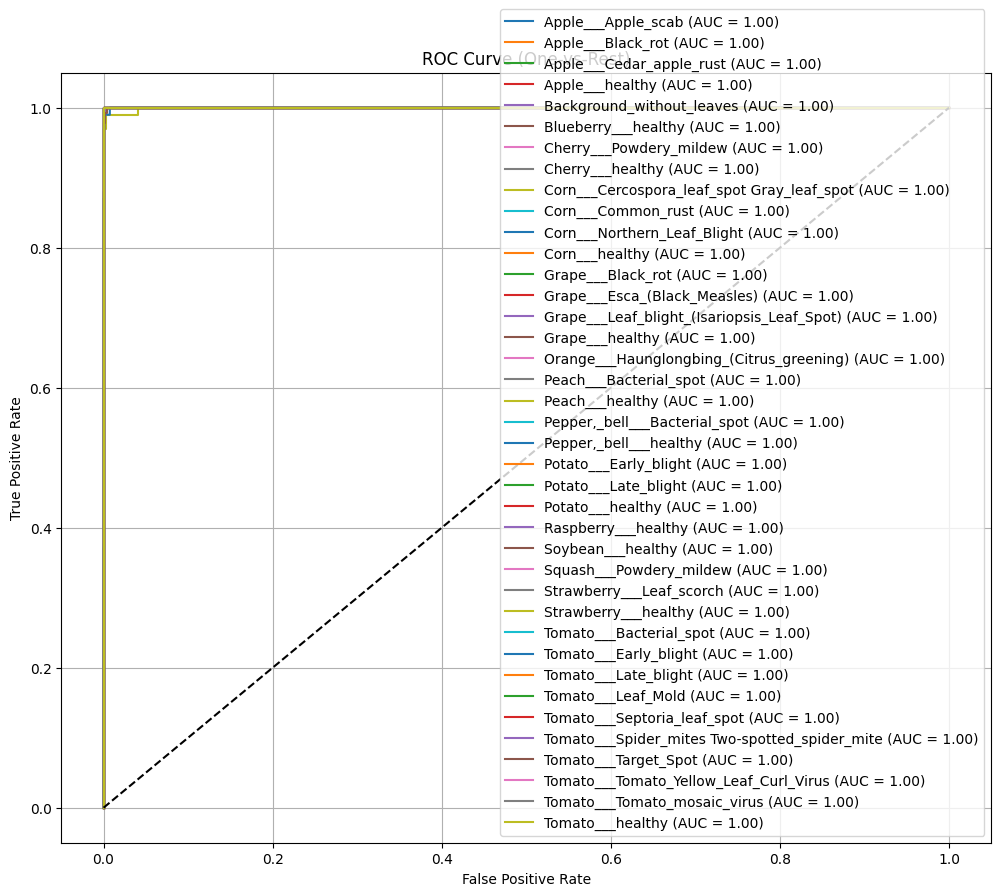

In [ ]:
# ROC Curve
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
plt.figure(figsize=(12, 10))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

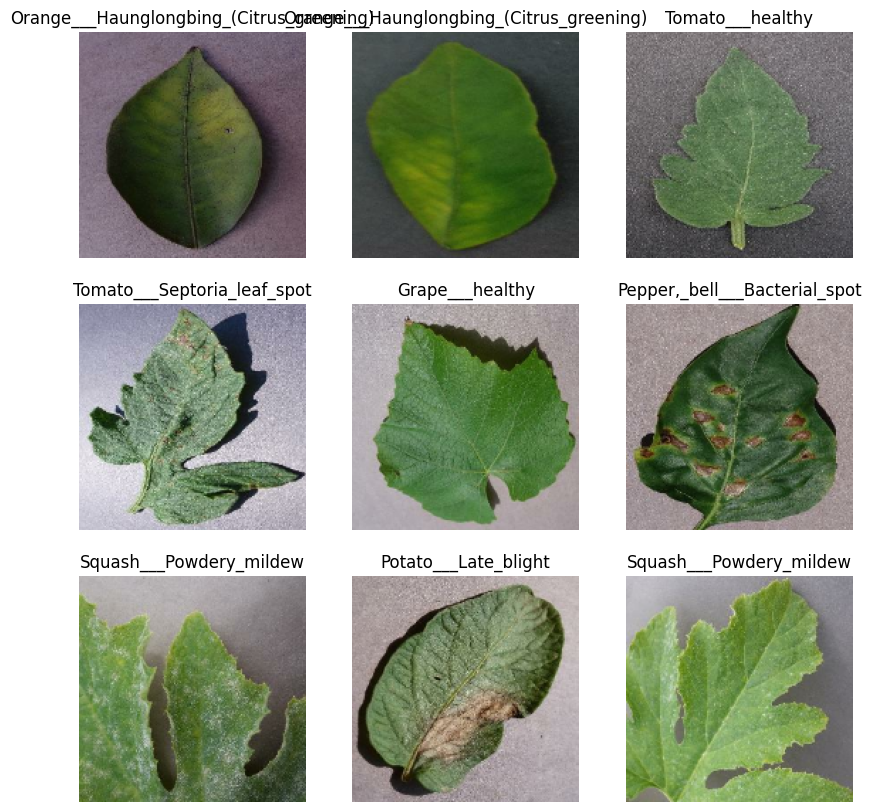

In [ ]:
# 8. Visualize Predictions
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [ ]:
# 9. Save Model
model.save("plant_disease_densenet_model.keras")
model.save("/content/drive/MyDrive/plant_disease_densenet_model.keras")

NameError: name 'model' is not defined